# Tutorial 13 (JAX): Vector Quantization

In [1]:
## Standard libraries
import os
import math
import numpy as np
from typing import Sequence, Any
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()

## tqdm for loading bars
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.training.train_state import TrainState

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (i.e. STL10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial13_jax"

print("Device:", jax.devices()[0])

Device: gpu:0


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial13/"
# Files to download
pretrained_files = []
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

### Data preparation

In [3]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.5) * 2.0
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

train_transforms = transforms.Compose([
                                 transforms.Resize((64, 64)),
                                 transforms.RandomHorizontalFlip(),
                                 image_to_numpy
                                ])
test_transforms = transforms.Compose([
                                 transforms.Resize((64, 64)),
                                 image_to_numpy
                                ])

train_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                   transform=train_transforms)
test_data = STL10(root=DATASET_PATH, split='train', download=True,
                  transform=test_transforms)
test_data, val_data = data.random_split(test_data, [3000, 2000], 
                                        generator=torch.Generator().manual_seed(42))

train_loader = data.DataLoader(train_data,
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               # persistent_workers=True,
                               generator=torch.Generator().manual_seed(42)
                              )
val_loader   = data.DataLoader(val_data,
                               batch_size=64,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               # persistent_workers=True
                              )
test_loader  = data.DataLoader(test_data,
                               batch_size=64,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               # persistent_workers=True
                              )

Files already downloaded and verified
Files already downloaded and verified


In [54]:
def imgs_to_grid(imgs, pads=2, num_rows=4):
    imgs = np.pad(imgs, ((0,0), (pads,pads), (pads,pads), (0,0)))
    imgs = np.reshape(imgs, (num_rows, -1, *imgs.shape[1:]))
    imgs = imgs.swapaxes(1, 2)
    imgs = imgs.reshape(num_rows*imgs.shape[1], -1, imgs.shape[-1])
    imgs = np.pad(imgs, ((pads,pads), (pads,pads), (0,0)))
    imgs = (imgs + 1.) / 2.
    return imgs

def show_imgs(imgs, num_rows=4, title=''):
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(imgs_to_grid(imgs, num_rows=num_rows))
    plt.axis('off')
    plt.show()

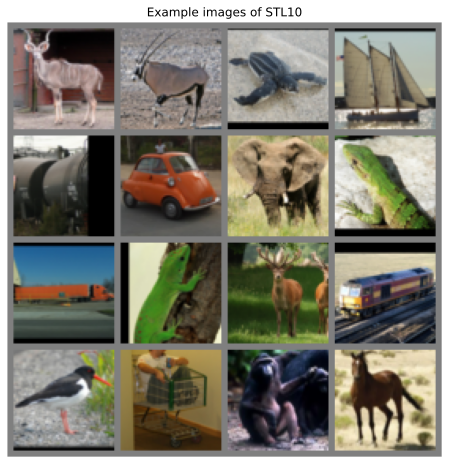

In [57]:
show_imgs(np.stack([train_data[i][0] for i in range(16)], axis=0), 
          title='Example images of STL10')

## VQVAE model

In [6]:
class Norm(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        return nn.GroupNorm(num_groups=None, group_size=16, epsilon=1e-6)(x)

In [7]:
class PositionEmbedding(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        _, H, W, C = x.shape
        grid = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, H),
                                      jnp.linspace(-1, 1, W)), 
                         axis=-1)[None]
        feats = nn.Conv(C, kernel_size=(1, 1))(grid)
        x = x + feats
        return x

In [8]:
nn.linear.default_kernel_init

<function jax._src.nn.initializers.variance_scaling.<locals>.init(key, shape, dtype=<class 'jax.numpy.float64'>)>

In [9]:
# Conv initialized with kaiming int, but uses fan-out instead of fan-in mode
# Fan-out focuses on the gradient distribution, and is commonly used in ResNets
resnet_kernel_init = nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal')

### Encoder

In [10]:
class EncoderResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x):
        # Network representing F
        z = Norm()(x)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = PositionEmbedding()(z)
        z = Norm()(z)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)

        if self.subsample:
            x = Norm()(x)
            x = self.act_fn(x)
            x = nn.Conv(self.c_out,
                        kernel_size=(1, 1),
                        strides=(2, 2),
                        kernel_init=resnet_kernel_init,
                        use_bias=False)(x)

        x_out = z + x
        return x_out

In [11]:
class AttnBlock(nn.Module):

    @nn.compact
    def __call__(self, x):
        residual = x
        x = Norm()(x)
        
        qkv = nn.Conv(3*x.shape[-1], kernel_size=(1, 1))(x)
        query, key, value = qkv.split(3, axis=-1)

        # compute attentions
        B, H, W, C = query.shape
        query = query.reshape((B, H * W, C))
        key = key.reshape((B, H * W, C))
        attn_weights = jnp.einsum('...qc,...kc->...qk', query, key)
        attn_weights = attn_weights * (int(C) ** -0.5)
        attn_weights = nn.softmax(attn_weights, axis=-1)

        ## attend to values
        value = value.reshape((B, H * W, C))
        x = jnp.einsum('...kc,...qk->...qc', value, attn_weights)
        x = x.reshape((B, H, W, C))

        x = nn.Conv(x.shape[-1], kernel_size=(1, 1))(x)
        x = x + residual
        return x

In [12]:
module = AttnBlock()
inp = random.normal(random.PRNGKey(0), (64, 12, 12, 256))
params = module.init(random.PRNGKey(0), inp)
out = module.apply(params, inp)
out.shape

(64, 12, 12, 256)

In [13]:
class Encoder(nn.Module):
    num_blocks : Sequence[int]
    c_hidden : Sequence[int]
    vocab_dim : int
    act_fn : callable = nn.swish
        
    def setup(self):
        self.in_conv = nn.Conv(self.c_hidden[0], kernel_size=(3, 3),
                               kernel_init=resnet_kernel_init,
                               use_bias=False)
        block_modules = []
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0)  # Subsample the first block of each group, except the very first one.
                block_modules.append(
                    EncoderResNetBlock(act_fn=self.act_fn,
                                       subsample=subsample,
                                       c_out=self.c_hidden[block_idx])
                )
                if block_idx > 1 and bc < block_count - 1:
                    block_modules.append(AttnBlock())
        self.block_modules = block_modules
                
        self.out_norm = Norm()
        self.out_conv = nn.Conv(self.vocab_dim, kernel_size=(3, 3),
                                kernel_init=resnet_kernel_init,
                                use_bias=True)
        
    def __call__(self, x):
        x = self.in_conv(x)
        for layer in self.block_modules:
            x = layer(x)
        x = self.out_norm(x)
        x = self.act_fn(x)
        x = self.out_conv(x)
        return x

In [14]:
module = Encoder(num_blocks=[2, 2, 3],
                 c_hidden=[64, 128, 256],
                 vocab_dim=256)
inp, _ = next(iter(train_loader))
variables = module.init(random.PRNGKey(0), inp)
# params, batch_stats = variables['params'], variables['batch_stats']
out = module.apply(variables, # {'params': params, 'batch_stats': batch_stats},
                   inp)
#                    mutable=['batch_stats'])
vecs = out
print(vecs.shape)

(64, 16, 16, 256)


### Decoder

In [15]:
class DecoderResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
        
    @nn.compact
    def __call__(self, x):
        # Network representing F
        z = Norm()(x)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = PositionEmbedding()(z)
        z = Norm()(z)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        
        if x.shape[-1] != z.shape[-1]:
            x = Norm()(x)
            x = self.act_fn(x)
            x = nn.Conv(self.c_out, kernel_size=(1, 1),
                        kernel_init=resnet_kernel_init,
                        use_bias=False)(z)
        
        return x + z

In [16]:
class Upsample(nn.Module):
    scale_factor : float = 2.0
    method : str = 'nearest'
    
    @nn.compact
    def __call__(self, x):
        B, H, W, C = x.shape
        x = jax.image.resize(x, 
                             shape=(B, int(H * self.scale_factor), int(W * self.scale_factor), C),
                             method=self.method)
        return x

In [20]:
class Decoder(nn.Module):
    num_blocks : Sequence[int]
    c_hidden : Sequence[int]
    c_out : int
    act_fn : callable = nn.swish
        
    def setup(self):
        self.in_conv = nn.Conv(self.c_hidden[0], kernel_size=(1, 1),
                               kernel_init=resnet_kernel_init,
                               use_bias=False)
        
        block_modules = []
        for block_idx, block_count in enumerate(self.num_blocks):
            if block_idx > 0:
                block_modules.append(Upsample())
            for bc in range(block_count):
                channel_change = (bc == 0 and block_idx > 0)
                block_modules.append(
                    DecoderResNetBlock(act_fn=self.act_fn,
                                       c_out=self.c_hidden[block_idx])
                )
                if block_idx == 0 and bc < block_count - 1:
                    block_modules.append(AttnBlock())
                
        self.block_modules = block_modules
        self.out_norm = Norm()
        self.out_conv = nn.Conv(self.c_out, kernel_size=(3, 3))
        
    def __call__(self, x):
        x = self.in_conv(x)
        for layer in self.block_modules:
            x = layer(x)
        x = self.out_norm(x)
        x = self.act_fn(x)
        x = self.out_conv(x)
        x = nn.tanh(x)
        return x

In [21]:
module = Decoder(num_blocks=[3, 2, 2],
                 c_hidden=[256, 128, 64],
                 c_out=3)
inp = random.normal(random.PRNGKey(0), (64, 16, 16, 256))
variables = module.init(random.PRNGKey(0), inp)
out = module.apply(variables, inp)
print(out.shape)

(64, 64, 64, 3)


### Vector Quantization

In [22]:
class VQEmbedding(nn.Module):
    vocab_size : int
    vocab_dim : int
    
    def setup(self):
        self.codebook = nn.Embed(self.vocab_size, self.vocab_dim)
        
    def __call__(self, z):
        z_flatten = z.reshape(-1, z.shape[-1])
        
        # dummy op to init the weights, so we can access them below
        self.codebook(jnp.ones((1, 1), dtype="i4"))

        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z
        embed_weights = self.variables["params"]["codebook"]["embedding"]
        distance = (
            jnp.sum(z_flatten ** 2, axis=1, keepdims=True)
            + jnp.sum(embed_weights ** 2, axis=1)
            - 2 * jnp.dot(z_flatten, embed_weights.T)
        )

        # get quantized latent vectors
        embed_idxs = jnp.argmin(distance, axis=1)
        z_embeds = self.codebook(embed_idxs).reshape(z.shape)
        z_q = z + jax.lax.stop_gradient(z_embeds - z)
        
        return z_q, z_embeds, embed_idxs
    
    def embed(self, embed_idxs):
        return self.codebook(embed_idxs)

In [23]:
module = VQEmbedding(vocab_size=512, vocab_dim=256)
inp = random.normal(random.PRNGKey(0), (64, 16, 16, 256))
params = module.init(random.PRNGKey(0), inp)
z_q, z_embeds, embed_idxs = module.apply(params, inp)
z_q.shape

(64, 16, 16, 256)

### VQVAE model

In [24]:
def mse_loss(pred, target):
    return ((pred - jax.lax.stop_gradient(target))**2).mean()


class VQVAE(nn.Module):
    vocab_size : int
    vocab_dim : int
    beta : float
    resnet_blocks : Sequence[int] = (1, 2, 2)
    resnet_hidden : Sequence[int] = (32, 64, 128)
    
    def setup(self):
        # Encoder network (ResNet)
        self.encoder = Encoder(num_blocks=self.resnet_blocks,
                               c_hidden=self.resnet_hidden,
                               vocab_dim=self.vocab_dim,
                               act_fn=nn.swish)
        # Vector quantized bottleneck layer
        self.vector_quantization = VQEmbedding(vocab_size=self.vocab_size,
                                               vocab_dim=self.vocab_dim)
        # Decoder network (ResNet, mirrored version of Encoder)
        self.decoder = Decoder(num_blocks=self.resnet_blocks[::-1],
                               c_hidden=self.resnet_hidden[::-1],
                               c_out=3,
                               act_fn=nn.swish)
        
    def __call__(self, x):
        z = self.encoder(x)
        z_quantized, z_embeddings, _ = self.vector_quantization(z)
        x_rec = self.decoder(z_quantized)
        
        rec_loss = mse_loss(x_rec, x)
        embed_loss = mse_loss(z_embeddings, z)
        quant_loss = mse_loss(z, z_embeddings)
        
        loss = rec_loss + embed_loss + self.beta * quant_loss
        
        metrics = {'loss': loss,
                   'rec_loss': rec_loss,
                   'l1_dist': jnp.abs(x_rec - x).mean(),
                   'embed_loss': embed_loss,
                   'quant_loss': self.beta * quant_loss}
        
        return loss, metrics
        
    def reconstruct(self, x):
        z = self.encoder(x)
        z, _, _ = self.vector_quantization(z)
        x_rec = self.decoder(z)
        return x_rec
    
    def encode(self, x):
        z = self.encoder(x)
        _, _, embed_idxs = self.vector_quantization(z)
        return embed_idxs
    
    def decode(self, embed_idxs):
        z = self.vector_quantization.embed(embed_idxs)
        x_rec = self.decoder(z)
        return x_rec

### Trainer module

In [44]:
class TrainerModule:

    def __init__(self, exmp_imgs, lr=5e-4, seed=42, **model_hparams):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.seed = seed
        self.exmp_imgs = exmp_imgs
        self.model_name = 'VQVAE'
        print('Model', self.model_name)
        # Create empty model. Note: no parameters yet
        self.model = VQVAE(**model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'{self.model_name}/')
        self.logger = SummaryWriter(log_dir=self.log_dir)
        self.logged_orig_imgs = False
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Training function
        def train_step(state, batch):
            loss_fn = lambda params: self.model.apply(params, batch)
            # Get loss, gradients for loss, and other outputs of loss function
            (_, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads)
            return state, metrics
        # Eval function
        def eval_step(state, batch):
            # Return the accuracy for a single batch
            _, metrics = self.model.apply(state.params, batch)
            return metrics
        # Reconstruction function
        def reconst_func(state):
            x_rec = self.model.bind(state.params).reconstruct(self.exmp_imgs[:16])
            return jax.device_get(x_rec)
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)
        self.reconst_func = jax.jit(reconst_func)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = jax.random.PRNGKey(self.seed)
        params = self.model.init(init_rng, exmp_imgs)
        self.state = TrainState(step=0,
                                apply_fn=self.model.apply,
                                params=params,
                                tx=None, opt_state=None)

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=50,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=1e-2*self.lr
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=self.state.params,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval reconstruction
        best_eval = 1e6
        self.log_reconstructions(0)
        print('Training starts')
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 1 == 0:
                eval_metrics = self.eval_model(val_loader)
                print(f'[Epoch {epoch_idx}]', ', '.join([f'{key}: {eval_metrics[key]:5.4f}' for key in eval_metrics]))
                for key in eval_metrics:
                    self.logger.add_scalar(f'val/{key}', eval_metrics[key], global_step=epoch_idx)
                if eval_metrics['rec_loss'] <= best_eval:
                    best_eval = eval_metrics['rec_loss']
                    self.save_model(step=epoch_idx)
            if epoch_idx % 10 == 0:
                self.log_reconstructions(epoch_idx)
            self.logger.flush()

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(float)
        for imgs, _ in tqdm(train_loader, desc='Training', leave=False):
            self.state, batch_metrics = self.train_step(self.state, imgs)
            for key in batch_metrics:
                metrics[key] += batch_metrics[key]
        num_train_steps = len(train_loader)
        for key in metrics:
            avg_val = metrics[key].item() / num_train_steps
            self.logger.add_scalar(f'train/{key}', avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        count = 0
        metrics = defaultdict(float)
        for imgs, _ in data_loader:
            batch_metrics = self.eval_step(self.state, imgs)
            count += imgs.shape[0]
            for key in batch_metrics:
                metrics[key] += batch_metrics[key] * imgs.shape[0]
        metrics = {key: metrics[key].item() / count for key in metrics}
        return metrics
    
    def log_reconstructions(self, epoch_idx):
        x_rec = self.reconst_func(self.state)
        self.logger.add_image('reconstructions', imgs_to_grid(x_rec), global_step=epoch_idx, dataformats='HWC')
        
        if not self.logged_orig_imgs:
            x_ori = imgs_to_grid(self.exmp_imgs[:x_rec.shape[0]])
            self.logger.add_image('originals', x_ori, global_step=epoch_idx, dataformats='HWC')
            self.logged_orig_imgs = True
        

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        state_dict.pop('batch_stats')
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict,
                                       tx=self.state.tx if self.state.tx else optax.sgd(0.1)   # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [45]:
def train_vqvae(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    trainer.model_bd = trainer.model.bind(trainer.state.params)
    return trainer, {'val': val_acc, 'test': test_acc}

In [46]:
trainer, results = train_vqvae(vocab_size=512,
                               vocab_dim=256,
                               beta=0.25,
                               exmp_imgs=next(iter(train_loader))[0])

Model VQVAE


In [49]:
print(f'Test reconstruction L1: {results["test"]["rec_loss"]:4.3f}')

Test reconstruction L1: 0.008


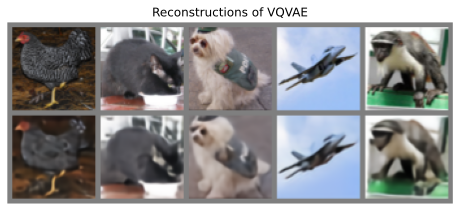

In [59]:
imgs, _ = next(iter(val_loader))
imgs = imgs[5:10]
x_rec = trainer.model_bd.reconstruct(imgs)
imgs = np.stack([imgs, x_rec], axis=0).reshape(-1, *imgs.shape[1:])
show_imgs(imgs, num_rows=2, title='Reconstructions of VQVAE')

## Analyzing the VQVAE

- Overall distribution
- Check specific codes and highlight in an image where this code is used
- New combinations of codes => does this make any sense?

## Generative modeling with VQVAE

- Random uniform sampling of codes
- TODO: Train Transformer on codespace of VQVAE